# Model training end evaluation

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings("ignore", message="")

**Load Data**

In [2]:
df = pd.read_csv("../data/prepared_data.csv")

**Devide the dataset**

Use train_test_split from scikit-learn to split the data into training and test sets.

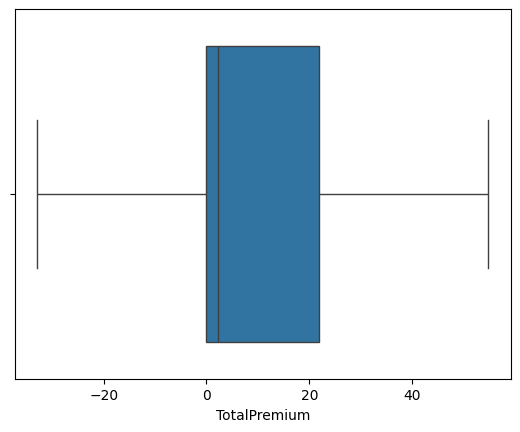

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df['TotalPremium'])
plt.show()

In [4]:
from preparation import EDA

In [5]:
eda = EDA(df)

In [6]:
# Define features and target variable
X = df.drop(columns=['TotalPremium'])
y = df['TotalPremium']

# Split data into training and test sets
X_train, X_test, y_train, y_test=eda.split_data("TotalPremium")
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To ensure that the model generalizes well to unseen data, the dataset was split into training and test sets. Typically, the split is done in either a 70:30 or 80:20 ratio.

- Train Set: Used to train the model.
- Test Set: Used to evaluate model performance on unseen data.
**Modeling Techniques**

The following machine learning models were trained using the training data:

- Linear Regression: A baseline regression model that assumes a linear - relationship between the features and the target.
- Decision Tree: A non-linear model that learns simple decision rules inferred from the data.
- Random Forest: An ensemble model that combines multiple decision trees to improve prediction accuracy and generalization.
- XGBoost: A powerful boosting algorithm that iteratively improves model performance by focusing on difficult-to-predict samples.

#### Linear Regression:

In [7]:
# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"R-squared (R2): {r2_lr:.2f}")

Mean Squared Error (MSE): 276.15
Mean Absolute Error (MAE): 11.75
R-squared (R2): 0.43


##### Visualize


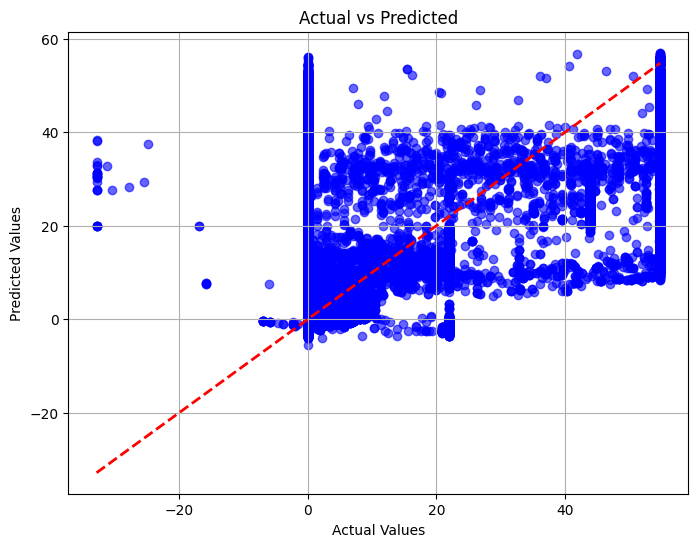

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

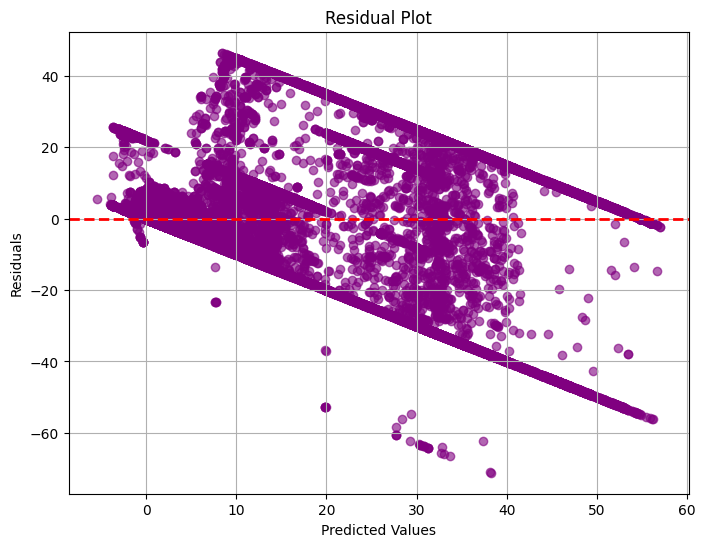

In [9]:
residuals = y_test - y_pred_lr

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lr, residuals, alpha=0.6, color="purple")
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()


Featured Importance

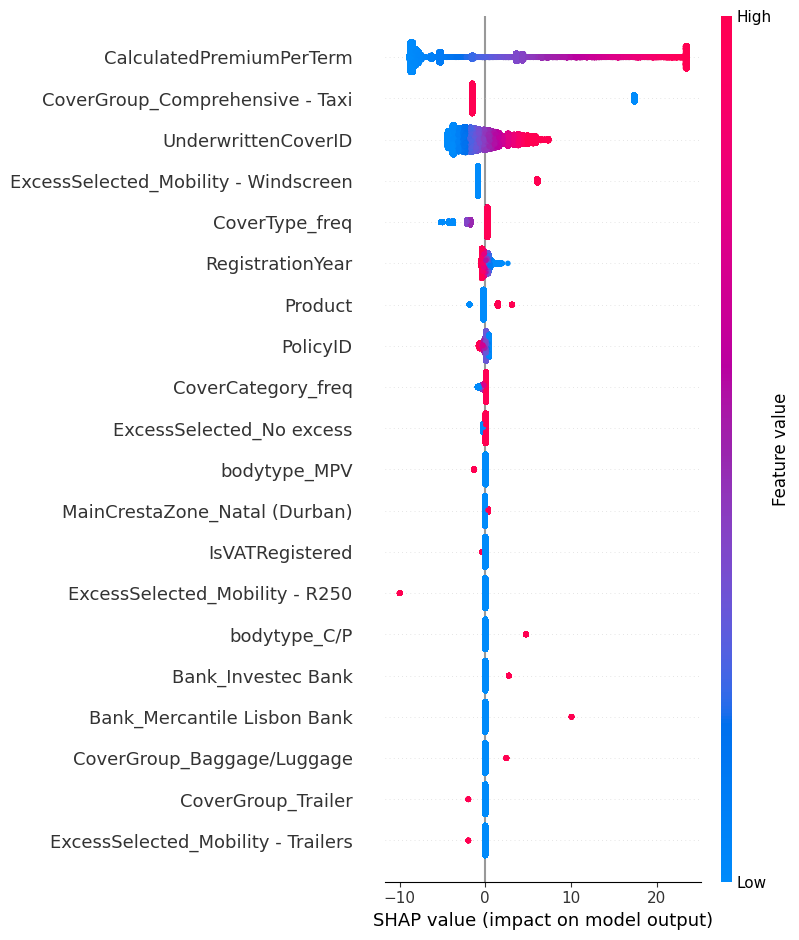

In [10]:
import shap

explainer = shap.Explainer(lr_model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

In [11]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X_train.columns, 
    mode="regression"
)

# Explain a single prediction
exp = explainer.explain_instance(X_test.iloc[0].values, lr_model.predict, num_features=5)
exp.show_in_notebook()


Decsision Tree:

In [12]:
# Initialize and train the model
import numpy as np
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mape_dt = np.mean(np.abs((y_test - y_pred_dt) / y_test)) * 100



r2_dt = r2_score(y_test, y_pred_dt)

# Use cross-validation to ensure the model generalizes well
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print out validation score
print("Cross-Validated MSE:", -np.mean(cv_scores))
print("RMSE",rmse_dt)
print("MAPE",mape_dt)
print("R²", r2_dt)


Cross-Validated MSE: 72.69255857677942
RMSE 8.342522986685907
MAPE inf
R² 0.8554892635885526


#### Visualize the model

1. Decision Tree Structure
Visualize the tree structure to understand how splits are made:

Textual representation of the decision tree:
|--- CalculatedPremiumPerTerm <= -0.29
|   |--- CalculatedPremiumPerTerm <= -0.53
|   |   |--- CalculatedPremiumPerTerm <= -0.70
|   |   |   |--- CalculatedPremiumPerTerm <= -0.72
|   |   |   |   |--- CalculatedPremiumPerTerm <= -0.74
|   |   |   |   |   |--- CalculatedPremiumPerTerm <= -0.75
|   |   |   |   |   |   |--- CalculatedPremiumPerTerm <= -0.75
|   |   |   |   |   |   |   |--- CalculatedPremiumPerTerm <= -0.76
|   |   |   |   |   |   |   |   |--- CoverCategory_freq <= 0.57
|   |   |   |   |   |   |   |   |   |--- CalculatedPremiumPerTerm <= -0.76
|   |   |   |   |   |   |   |   |   |   |--- PolicyID <= -1.46
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- PolicyID >  -1.46
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- CalculatedPremiumPerTerm >  -0.76
|   |   |   |   |   |   |   |   |   |

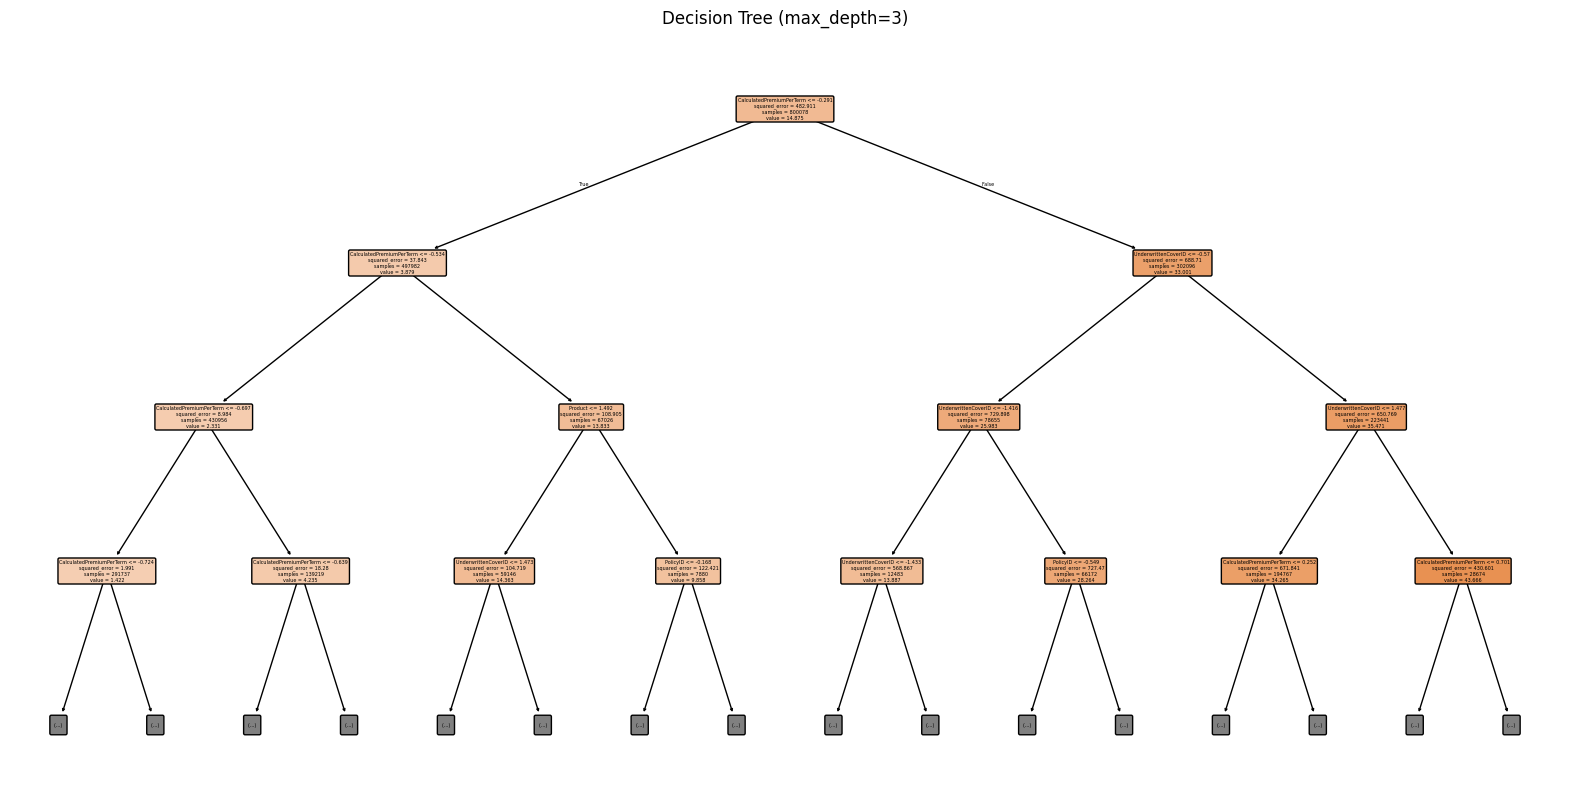

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

# Limit the tree depth for plotting
max_plot_depth = 3  # Adjust depth for visualization

# Generate a text representation for a quick overview (optional)
tree_text = export_text(dt_model, feature_names=list(X_train.columns))
print("Textual representation of the decision tree:")
print(tree_text)

# Plot the decision tree with limited depth
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model, 
    max_depth=max_plot_depth,  # Limit depth of visualization
    filled=True, 
    feature_names=X_train.columns, 
    rounded=True
)
plt.title(f"Decision Tree (max_depth={max_plot_depth})")
plt.savefig("decision_tree_limited_depth.png", dpi=300)  # Save the plot for later viewing
plt.show()


2. Feature Importance:

Decision Trees provide feature importance scores:

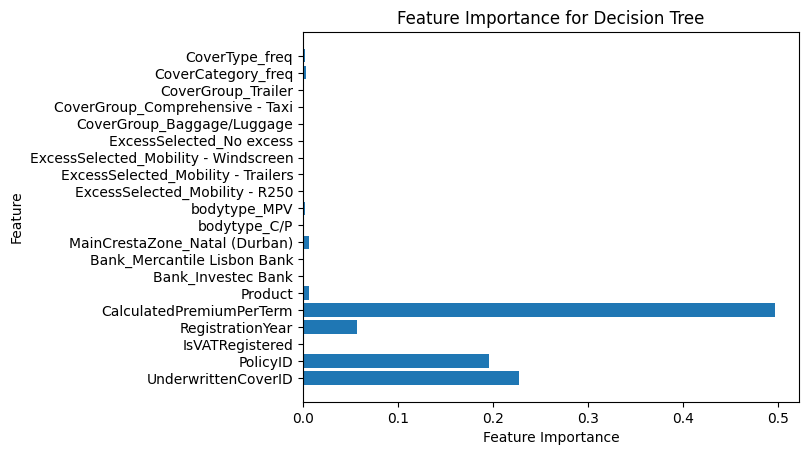

In [14]:
importances = dt_model.feature_importances_
plt.barh(X_train.columns, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for Decision Tree")
plt.show()


3. Prediceted vs Actual plot

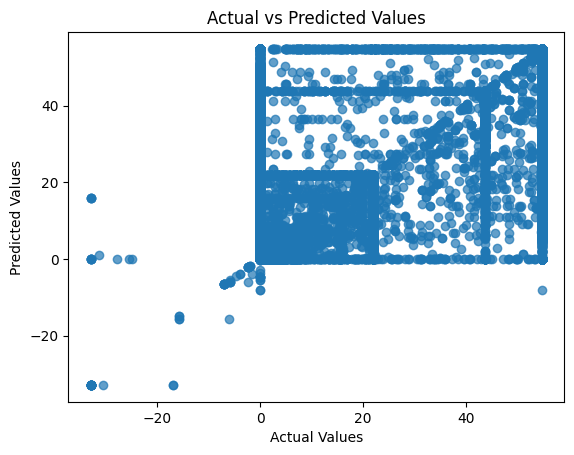

In [15]:
plt.scatter(y_test, y_pred_dt, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


4. Residual plot

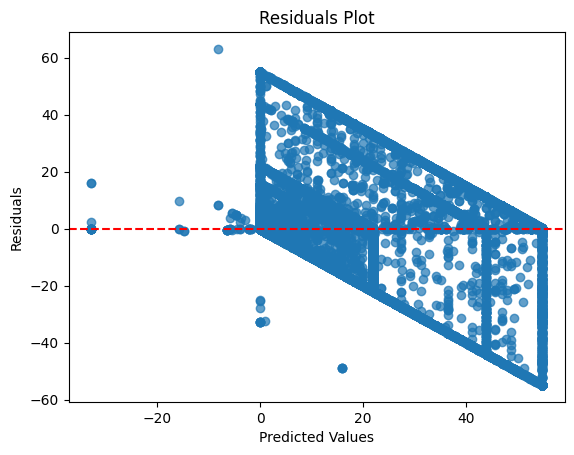

In [16]:
residuals = y_test - y_pred_dt
plt.scatter(y_pred_dt, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()


5. Generate SHAPE value

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


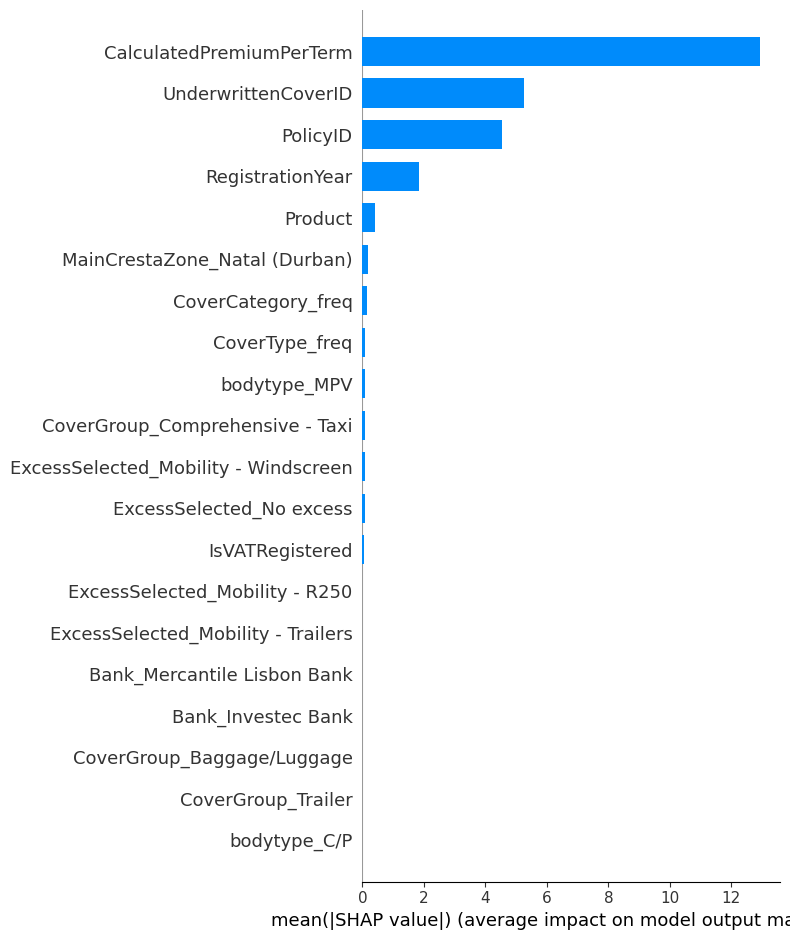

In [17]:
# Use a subset of the test data to speed up the explanation
X_test_subset = X_test.sample(n=100, random_state=42)  # Sample 1000 rows from X_test

# Initialize KernelExplainer (slower but more flexible)
explainer = shap.KernelExplainer(dt_model.predict, X_test_subset)

# Compute SHAP values for the subset of the test data
shap_values = explainer.shap_values(X_test_subset)

# Plot summary
shap.summary_plot(shap_values, X_test_subset, plot_type="bar")


6. Visualize Individual prediction

In [18]:
shap.initjs()

# Generate the force plot for a single instance
force_plot = shap.force_plot(
    explainer.expected_value, 
    shap_values[0, :], 
    X_test.iloc[0, :]
)

# Save the plot to an HTML file
shap.save_html("../data/force_plot.html", force_plot)

print("The SHAP force plot has been saved to 'force_plot.html'. Open this file in your browser to view the visualization.")

The SHAP force plot has been saved to 'force_plot.html'. Open this file in your browser to view the visualization.


7. LIME Interpretation

In [19]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    X_train.values, 
    training_labels=y_train.values, 
    feature_names=X_train.columns.tolist(), 
    mode='regression'
)

explanation = explainer.explain_instance(X_test.iloc[0, :].values, dt_model.predict)
explanation.show_in_notebook()


Reandome Forest:

In [20]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
# Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Root Mean Squared Error (RMSE)
rmse_rf = mse_rf ** 0.5

# R-Squared (R²)
r2_rf = r2_score(y_test, y_pred_rf)

# Print metrics
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R²: {r2_rf}")

MAE: 2.687870290092765
MSE: 68.95634121375548
RMSE: 8.303995496973458
R²: 0.8568209421885424


**Cross Validation**

#### Visualize model's performance

1. Residual plot:
visualize residual to detect pattern and outlier

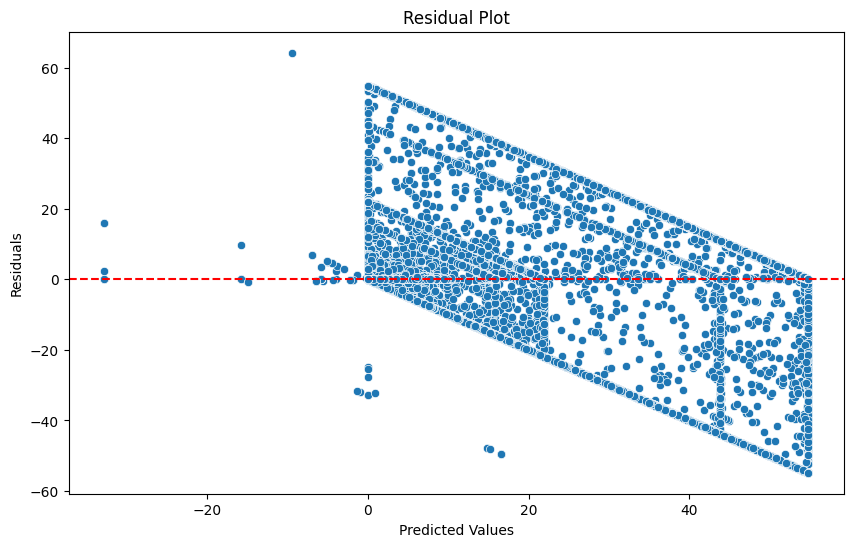

In [21]:


residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)  # Use x= and y=
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



2. Actual vs residual plot

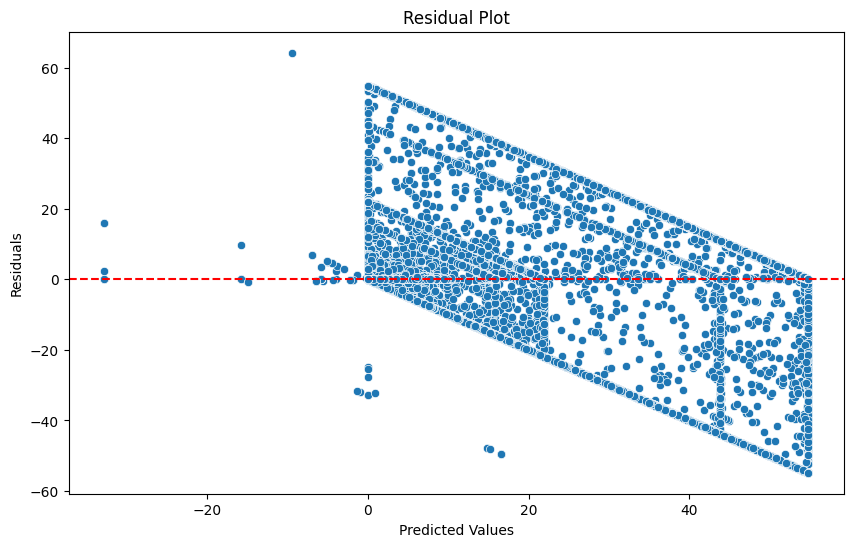

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)  # Use x= and y=
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



3. Feature importance

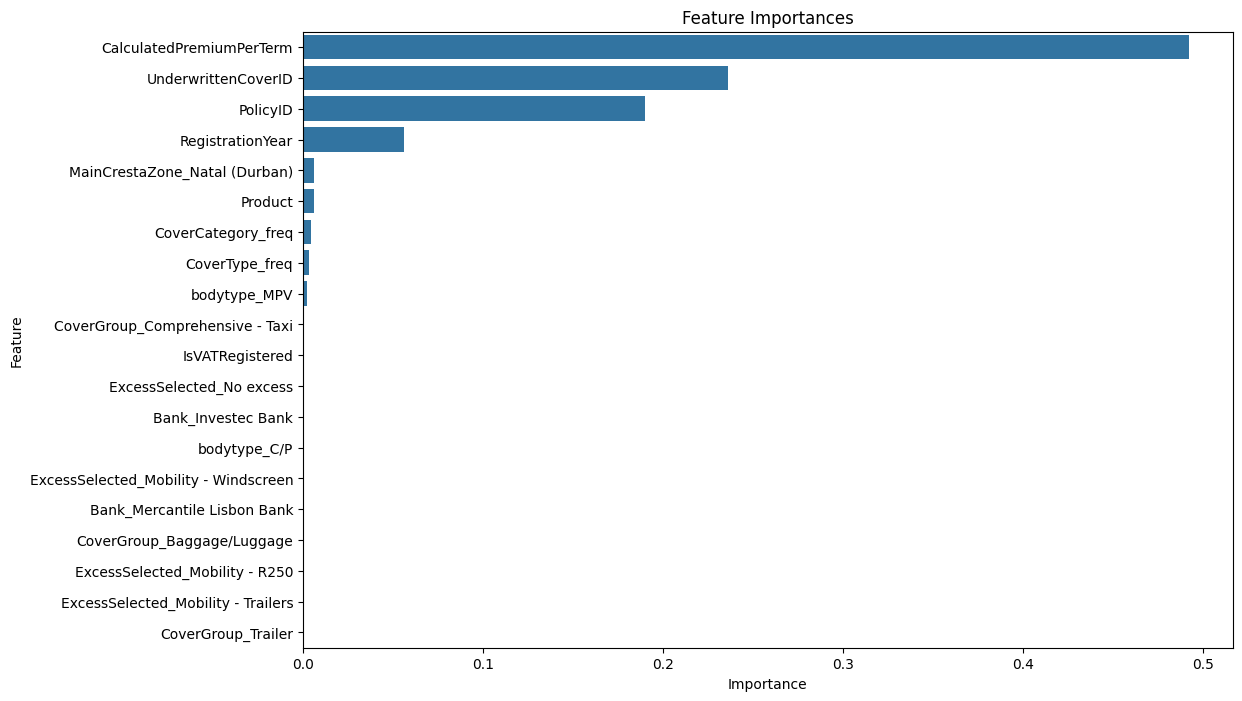

In [23]:
import pandas as pd

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()


4. Interprate with SHAP

In [ ]:
import shap

# Select a smaller sample or cluster
sample_X_test = shap.kmeans(X_test, 50)  # Representative 50 samples

# Convert DenseData to pandas DataFrame
sample_X_test_df = sample_X_test.data  # Get the actual data array
sample_X_test_df = pd.DataFrame(sample_X_test_df, columns=X_test.columns)  # Convert to DataFrame

# Run SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(sample_X_test_df)

# Summary plot
shap.summary_plot(shap_values, sample_X_test_df, feature_names=X_test.columns)

# Force plot for the first sample
shap.force_plot(explainer.expected_value[1], shap_values[1][0], sample_X_test_df.iloc[0])


5. Interprate with LIME

In [1]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')
explanation = explainer.explain_instance(X_test.iloc[0].values, rf_model.predict)

# Display the explanation for a single instance
explanation.show_in_notebook()


NameError: name 'X_train' is not defined

XGBoost:

In [13]:
# Initialize and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
# Mean Absolute Error (MAE)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Mean Squared Error (MSE)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Root Mean Squared Error (RMSE)
rmse_xgb = mse_xgb ** 0.5

# R-Squared (R²)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R²: {r2_xgb}")

**Corss validation**

In [ ]:
from sklearn.model_selection import cross_val_score

cv_mse = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cv_rmse = (-cv_mse.mean()) ** 0.5
print(f"Cross-Validated RMSE: {cv_rmse}")


#### Visualize model's performance

1. Residual plot:

In [ ]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(10, 6))
sns.scatterplot(y_pred_xgb, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

2. Residual vs predicted plot:

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(y_test, y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


3. Feature importance:

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

# Using matplotlib
# Get feature importance
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()



4. Interprate using SHAP:

In [ ]:
# Sample 100 representative data points
sample_X_test = shap.kmeans(X_test, 100)

# Run SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(sample_X_test)

# Summary plot
shap.summary_plot(shap_values, sample_X_test, feature_names=X_test.columns)

# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], sample_X_test.iloc[0])


5. Interprate using LIME:

In [ ]:
# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')

# Choose an instance to explain
explanation = explainer.explain_instance(X_test.iloc[0].values, xgb_model.predict)

# Display the explanation for a single instance
explanation.show_in_notebook()

## General Interpretation

1. #### Show All Models with Corresponding Evaluation Scores as DataFrame

In [ ]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Store evaluation metrics
model_metrics = []

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    model_metrics.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Create DataFrame for easy comparison
model_comparison_df = pd.DataFrame(model_metrics)
print(model_comparison_df)

2. #### Visualize All Models to Make it Simple for Model Comparison

In [ ]:
# Reshape data for plotting
metrics = ['MAE', 'MSE', 'RMSE', 'R²']
comparison_data = model_comparison_df.set_index('Model')[metrics]

# Plot
plt.figure(figsize=(12, 6))
comparison_data.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison: Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3. #### SHAP Interpretation for All Models

In [ ]:
# Create a SHAP explainer for each model
shap_values_dict = {}
for model_name, model in models.items():
    if model_name in ["Linear Regression"]:
        explainer = shap.Explainer(model, X_train)
    else:
        explainer = shap.TreeExplainer(model)
    
    shap_values_dict[model_name] = explainer.shap_values(X_test)

# Summary plots for each model
for model_name, shap_values in shap_values_dict.items():
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
    plt.title(f"SHAP Summary for {model_name}")
    plt.show()

4. #### LIME Interpretation for All Models

In [ ]:
lime_explanations = {}
for model_name, model in models.items():
    explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, mode='regression')
    explanation = explainer.explain_instance(X_test.iloc[0].values, model.predict)
    lime_explanations[model_name] = explanation

# Show LIME explanations for the first test instance
for model_name, explanation in lime_explanations.items():
    explanation.show_in_notebook(show_table=True, show_all=False)